# Merge the prophage counts based on the host's taxonomy

We are going to use the [GTDB](https://gtdb.ecogenomic.org/) taxonomy to count the number of prophages at different levels. Because of this, we merge with the GTDB metadata file.

In [1]:
# A lot of this is not used, but we import it so we have it later!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

import pandas as pd
import seaborn as sns
import numpy as np

import math
import re
import string

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_transposons

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA


In [2]:
phagesdf = read_phages(maxcontigs=-1)
phagesdf

Please note that this was run with git commit e73598a that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages, but after filtering we kept 3,265,453 prophages from 567,399 genomes

,assembly_accession,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000043285.1,ASM4328v1,705557.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0
1,GCA_000046685.1,ASM4668v1,1581384.0,1.0,1.0,18.0,3.0,0.0,15.0,97011.0
2,GCA_000046705.1,ASM4670v1,1931047.0,1.0,1.0,36.0,7.0,0.0,29.0,278490.0
3,GCA_000046845.1,ASM4684v1,3598621.0,1.0,1.0,13.0,3.0,4.0,6.0,83112.0
4,GCA_000047365.1,ASM4736v1,4840898.0,3.0,3.0,22.0,3.0,3.0,16.0,213427.0
...,...,...,...,...,...,...,...,...,...,...
567399,GCA_905187425.1,Xanthomonas_sp._CPBF_424_-_hybrid_assembly,4900930.0,1.0,1.0,46.0,7.0,9.0,30.0,214278.0
567400,GCA_905188235.1,ASM90518823v1,4963609.0,1.0,1.0,29.0,4.0,4.0,21.0,178993.0
567401,GCA_905219375.1,QI0054,3034314.0,1.0,1.0,12.0,4.0,3.0,5.0,178527.0
567402,GCA_905219385.1,QI0055,3034113.0,1.0,1.0,12.0,4.0,3.0,5.0,178526.0


### Read the data file

The metadata is from GTDB. The phage data is from us.


In [3]:
gtdb = read_gtdb()
gtdb

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,trna_aa_count,trna_count,trna_selenocysteine_count,domain,phylum,class,order,family,genus,species
0,GB_GCA_000006155.2,1916,93.12,0.00,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,...,16,31,0,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A anthracis
1,GB_GCA_000007385.1,0,99.82,0.00,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,...,20,53,0,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae
2,GB_GCA_000008605.1,67,100.00,0.00,235,f__Spirochaetaceae (UID2512),124,0.0,1048744,92.155875,...,20,45,0,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum
3,GB_GCA_000010565.1,0,100.00,0.63,295,p__Firmicutes (UID1022),158,0.0,2608397,86.217312,...,20,51,1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum
4,GB_GCA_000013845.2,0,100.00,0.00,332,o__Clostridiales (UID1375),124,0.0,2428396,82.037966,...,20,95,1,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,RS_GCF_902166935.1,0,99.62,0.09,1312,g__Klebsiella (UID5140),336,0.0,4894244,87.293148,...,20,87,1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae
191523,RS_GCF_902166945.1,0,99.94,0.72,1162,f__Enterobacteriaceae (UID5121),336,0.0,5162721,86.540042,...,20,86,1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae
191524,RS_GCF_902167295.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5737447,90.122088,...,20,58,0,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A
191525,RS_GCF_902167305.1,0,99.51,0.00,303,p__Bacteroidetes (UID2591),203,0.0,5738096,90.147873,...,20,58,0,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A


### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [4]:
acccol = 'assembly_accession'

## Sanity check

This is just to make sure that we are all working on the same data. Here, we make a temporary data frame that has the number of contigs and the number of basepairs in the genome, and use those to compare to see if we think we are working on the same thing.

If we find columns that are no good, we should delete them (but we don't, yay!)

In [5]:
def are_same(x):
    # currently fixing contig counts, so when that is done delete the next line and uncomment the one after
    return x['genome_size'] == x['Genome length']
    # return x['genome_size'] == x['Genome length'] and x['contig_count'] == x['Contigs']

comparison = pd.merge(gtdb[[acccol, 'contig_count', 'genome_size']],
                      phagesdf[[acccol, 'Contigs', 'Genome length']],
                      how='inner', left_on=acccol, right_on=acccol)

comparison['same'] = comparison.apply(are_same, axis=1)
# look for rows that are not the same
comparison[comparison['same']==False]

,assembly_accession,contig_count,genome_size,Contigs,Genome length,same


## Filter the genomes

We should probably filter out based on quality. We have three quality scores (mimag high/medium/low) plus the number of contigs. Lets make a little violin plot of the quality vs Total or Kept prophages.


In [6]:
qual = pd.merge(gtdb[[acccol, 'checkm_completeness', 'gc_percentage', 'contig_count', 'genome_size', 'mimag_high_quality', 'mimag_low_quality', 'mimag_medium_quality']],
                phagesdf[[acccol, 'Total Predicted Prophages', 'Kept']],
                how='inner', left_on=acccol, right_on=acccol)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5.0,0.0
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29.0,4.0
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5.0,1.0
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25.0,2.0
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12.0,2.0
...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158665.1,100.00,55.252894,23,6052172,t,f,f,29.0,0.0
126125,GCA_902158685.1,100.00,55.244893,38,6020052,t,f,f,27.0,2.0
126126,GCA_902158695.1,100.00,55.248393,59,6071600,t,f,f,27.0,5.0
126127,GCA_902158715.1,100.00,54.639170,65,6393461,t,f,f,31.0,1.0


In [7]:
def mimag_qual(x):
    if x['mimag_high_quality'] == 't':
        return "High"
    if x['mimag_medium_quality'] == 't':
        return "Medium"
    if x['mimag_low_quality'] == 't':
        return "Low"
    return "Unknown"

qual['Mimag quality'] = qual.apply(mimag_qual, axis=1)
qual

,assembly_accession,checkm_completeness,gc_percentage,contig_count,genome_size,mimag_high_quality,mimag_low_quality,mimag_medium_quality,Total Predicted Prophages,Kept,Mimag quality
0,GCA_000006155.2,93.12,35.101404,426,5370060,f,f,t,5.0,0.0,Medium
1,GCA_000007385.1,99.82,63.693289,1,4941439,t,f,f,29.0,4.0,High
2,GCA_000008605.1,100.00,52.775181,1,1138011,t,f,f,5.0,1.0,High
3,GCA_000010565.1,100.00,52.961104,1,3025375,t,f,f,25.0,2.0,High
4,GCA_000013845.2,100.00,28.230917,4,2960088,t,f,f,12.0,2.0,High
...,...,...,...,...,...,...,...,...,...,...,...
126124,GCA_902158665.1,100.00,55.252894,23,6052172,t,f,f,29.0,0.0,High
126125,GCA_902158685.1,100.00,55.244893,38,6020052,t,f,f,27.0,2.0,High
126126,GCA_902158695.1,100.00,55.248393,59,6071600,t,f,f,27.0,5.0,High
126127,GCA_902158715.1,100.00,54.639170,65,6393461,t,f,f,31.0,1.0,High


## How many genomes are low quality

In [8]:
print(f"There are {gtdb[gtdb['mimag_low_quality']=='t'].shape[0]} low quality genomes in GTDB")
print(f"There are {qual[qual['Mimag quality'] == 'Low'].shape[0]} low quality genomes in qual")

There are 17 low quality genomes in GTDB
There are 15 low quality genomes in qual


In [9]:
print(f"There are {gtdb.shape[0]:,} genomes in GTDB and {phagesdf.shape[0]:,} genomes in phages, but {qual.shape[0]:,} genomes in both")

There are 191,527 genomes in GTDB and 567,399 genomes in phages, but 126,129 genomes in both


In [10]:
qual.groupby('Mimag quality').agg('size')

Mimag quality
High       73023
Low           15
Medium     52953
Unknown      138
dtype: int64

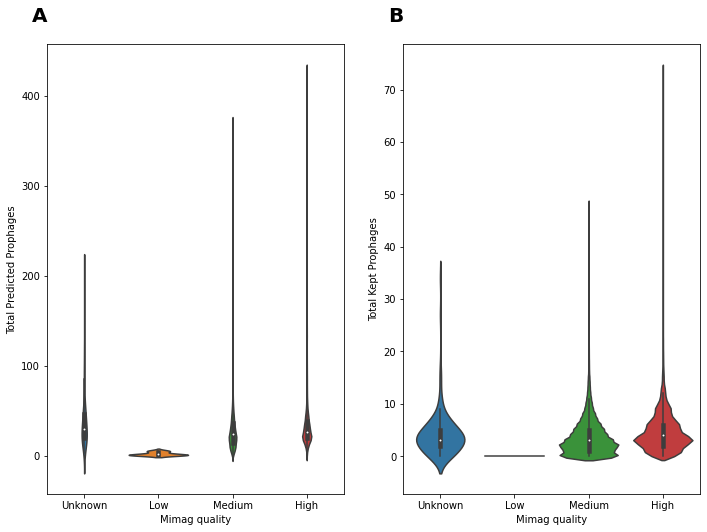

In [11]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Total Predicted Prophages', jitter=True, data=qual, ax=ax[0], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Total Predicted Prophages',  jitter=True, data=qual, alpha=0.1, ax=ax[0], color='k')

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax[1], order=['Unknown', 'Low', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax[1])
ax[1].set_ylabel("Total Kept Prophages")

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

plt.show()


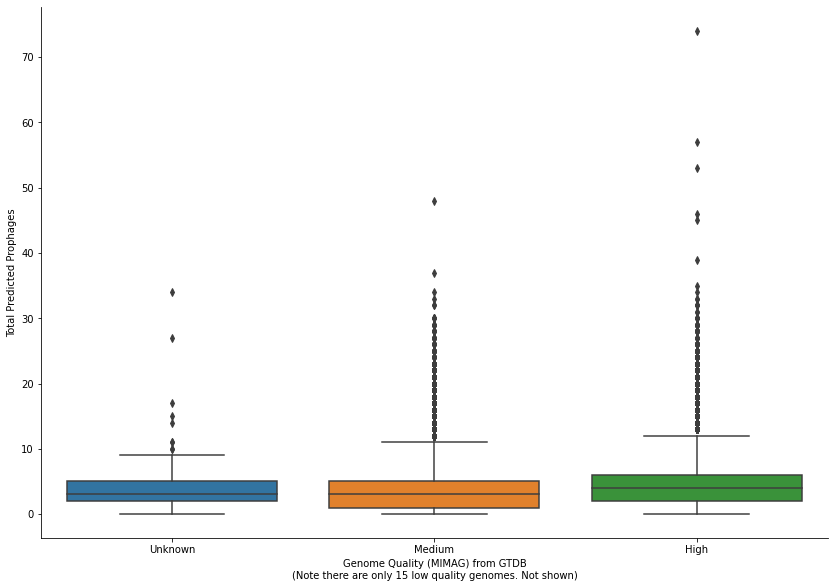

In [12]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

#sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax, order=['Unknown', 'Medium', 'High'])
sns.boxplot(x='Mimag quality', y='Kept', data=qual, ax=ax, order=['Unknown', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax)
ax.set_ylabel("Total Predicted Prophages")
xt="Genome Quality (MIMAG) from GTDB\n(Note there are only 15 low quality genomes. Not shown)"
ax.set_xlabel(xt)


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tight_layout()

fig.savefig('images/mimag_phages_box.png')
fig.savefig('images/mimag_phages_box.svg')

plt.show()

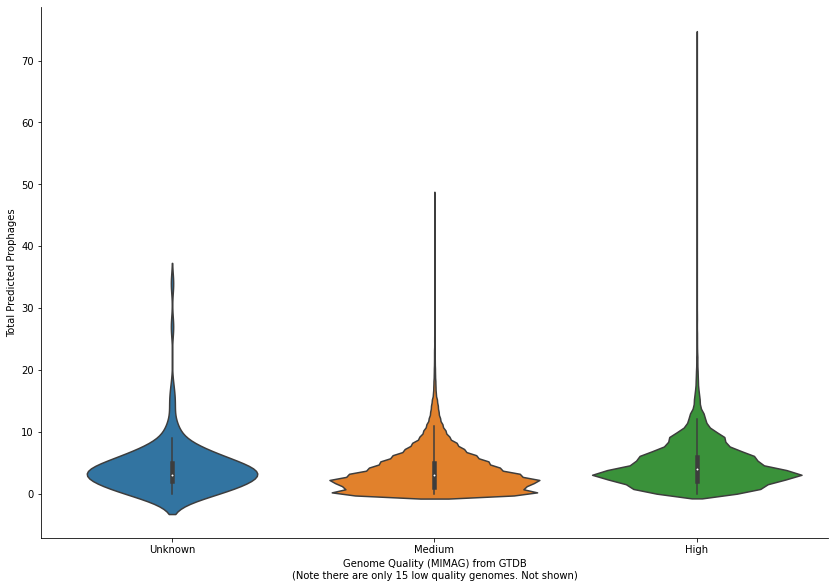

In [13]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.violinplot(x='Mimag quality', y='Kept', jitter=True, data=qual, ax=ax, order=['Unknown', 'Medium', 'High'])
#sns.stripplot(x='Mimag quality', y='Kept',  jitter=True, data=qual, color='k', alpha=0.1, ax=ax)
ax.set_ylabel("Total Predicted Prophages")
xt="Genome Quality (MIMAG) from GTDB\n(Note there are only 15 low quality genomes. Not shown)"
ax.set_xlabel(xt)


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tight_layout()

fig.savefig('images/mimag_phages_violin.png')
fig.savefig('images/mimag_phages_violin.svg')

plt.show()

### How does completeness/size compare with predictions?

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


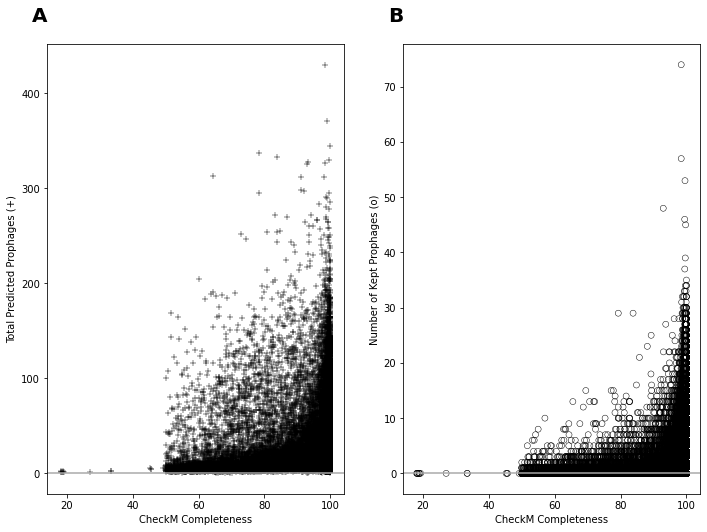

In [14]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Total Predicted Prophages', data=qual, marker='+', color='k', ax=ax[0])
sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
# ax2.grid(False)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('CheckM Completeness')
ax[1].set_xlabel('CheckM Completeness')
ax[0].axhline(y=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

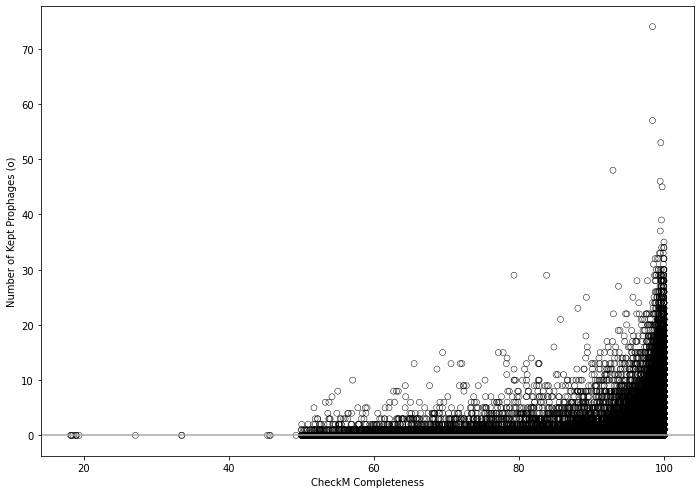

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))

sns.scatterplot(x='checkm_completeness', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax)
ax.set_ylabel('Number of Kept Prophages (o)')
ax.set_xlabel('CheckM Completeness')
ax.axhline(y=0, color='darkgrey')

fig.savefig("images/checkm_vs_phages.svg")

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


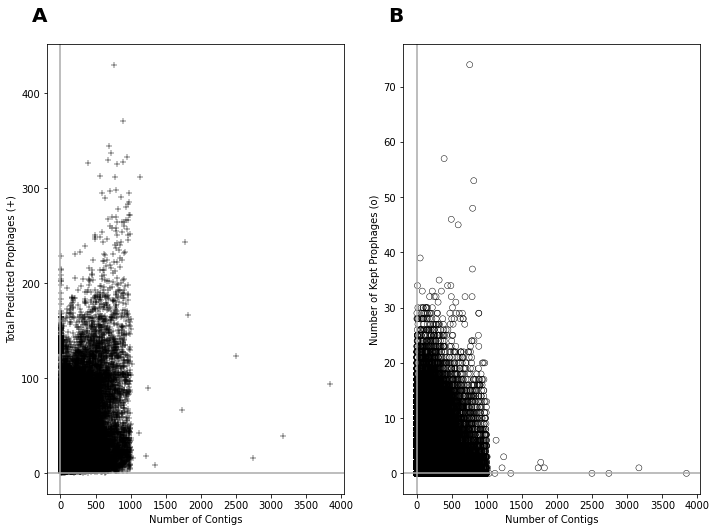

In [16]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])

ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')

for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages.svg")


c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


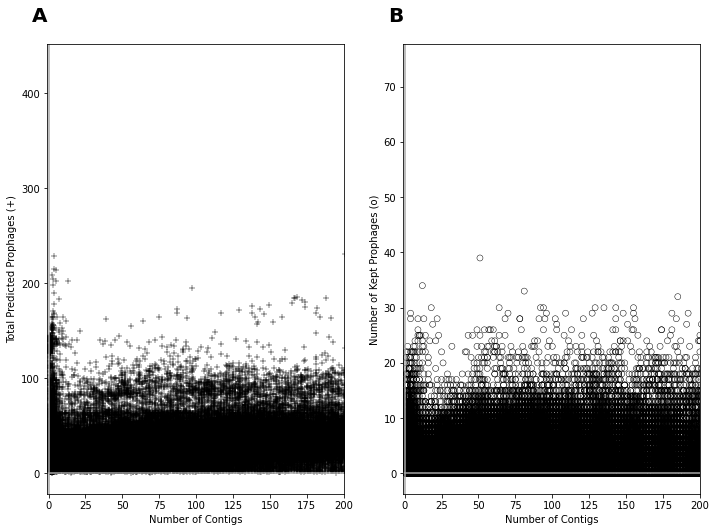

In [17]:
fig, ax = plt.subplots(1,2, figsize=(11.7,8.27))

sns.scatterplot(x='contig_count', y='Total Predicted Prophages', data=qual, marker='+', ax=ax[0], color='k')
sns.scatterplot(x='contig_count', y='Kept', data=qual, marker='o', facecolors='none', edgecolor='k', ax=ax[1])
ax[0].set_xlim(-1,200)
ax[1].set_xlim(-1,200)
ax[1].set_ylabel('Number of Kept Prophages (o)')
ax[0].set_ylabel('Total Predicted Prophages (+)')
ax[0].set_xlabel('Number of Contigs')
ax[1].set_xlabel('Number of Contigs')
ax[0].axhline(y=0, color='darkgrey')
ax[0].axvline(x=0, color='darkgrey')
ax[1].axhline(y=0, color='darkgrey')
ax[1].axvline(x=0, color='darkgrey')


for n, a in enumerate(ax):
    a.text(-0.05, 1.05, string.ascii_uppercase[n], transform=a.transAxes, size=20, weight='bold')

fig.savefig("images/contigs_vs_phages_0200.svg")

At the moment there doesn't seem to be an obvious reason to cut or cull any of these predictions!

# Compare CheckM and CheckV

See if high/medium/low phage genomes correlate with other predictions?

See the `checkv` workbook on how to do this... needs abstracting to a method DO NOT COPY THIS!

In [18]:
checkv = read_checkv()
base_pp = read_base_pp()
checkvb = pd.merge(base_pp, checkv, on='Prophage', how='inner')
acv = checkvb.groupby(['assembly_accession', 'checkv_quality']).agg({'checkv_quality': 'size'})
acvr = acv.rename({'checkv_quality':'checkv_count'}, axis=1).reset_index()
tmp = acvr[acvr['checkv_quality'] == 'Not-determined'][['assembly_accession', 'checkv_count']].rename({'checkv_count' : 'Not-determined'}, axis=1)
for t in ['Low-quality', 'Medium-quality', 'High-quality', 'Complete']:
    tmp2 = acvr[acvr['checkv_quality'] == t][['assembly_accession', 'checkv_count']].rename({'checkv_count' : t}, axis=1)
    tmp = pd.merge(tmp, tmp2, on='assembly_accession', how='outer')
checkvcounts = tmp.fillna(0)
checkvcounts

,assembly_accession,Not-determined,Low-quality,Medium-quality,High-quality,Complete
0,GCA_000003135.1,1.0,1.0,0.0,0.0,0.0
1,GCA_000003925.1,2.0,2.0,1.0,1.0,0.0
2,GCA_000005825.2,2.0,1.0,0.0,0.0,0.0
3,GCA_000006625.1,1.0,1.0,0.0,0.0,0.0
4,GCA_000006965.1,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
520147,GCA_901305565.1,0.0,0.0,0.0,0.0,1.0
520148,GCA_901319165.1,0.0,0.0,0.0,0.0,1.0
520149,GCA_901325505.1,0.0,0.0,0.0,0.0,1.0
520150,GCA_901331095.1,0.0,0.0,0.0,0.0,1.0


In [19]:
checkmv = pd.merge(qual[['assembly_accession', 'checkm_completeness', 'Kept', 'Mimag quality']], checkvcounts, on='assembly_accession', how='inner')
checkmv['checkm_round'] = round(checkmv['checkm_completeness'],0)
checkmv

,assembly_accession,checkm_completeness,Kept,Mimag quality,Not-determined,Low-quality,Medium-quality,High-quality,Complete,checkm_round
0,GCA_000007385.1,99.82,4.0,High,2.0,1.0,1.0,0.0,0.0,100.0
1,GCA_000008605.1,100.00,1.0,High,0.0,1.0,0.0,0.0,0.0,100.0
2,GCA_000010565.1,100.00,2.0,High,1.0,0.0,0.0,1.0,0.0,100.0
3,GCA_000013845.2,100.00,2.0,High,1.0,0.0,1.0,0.0,0.0,100.0
4,GCA_000014305.1,97.38,4.0,High,3.0,1.0,0.0,0.0,0.0,97.0
...,...,...,...,...,...,...,...,...,...,...
113141,GCA_902158655.1,100.00,4.0,High,0.0,1.0,1.0,2.0,0.0,100.0
113142,GCA_902158685.1,100.00,2.0,High,0.0,0.0,1.0,1.0,0.0,100.0
113143,GCA_902158695.1,100.00,5.0,High,1.0,0.0,1.0,3.0,0.0,100.0
113144,GCA_902158715.1,100.00,1.0,High,0.0,1.0,0.0,0.0,0.0,100.0


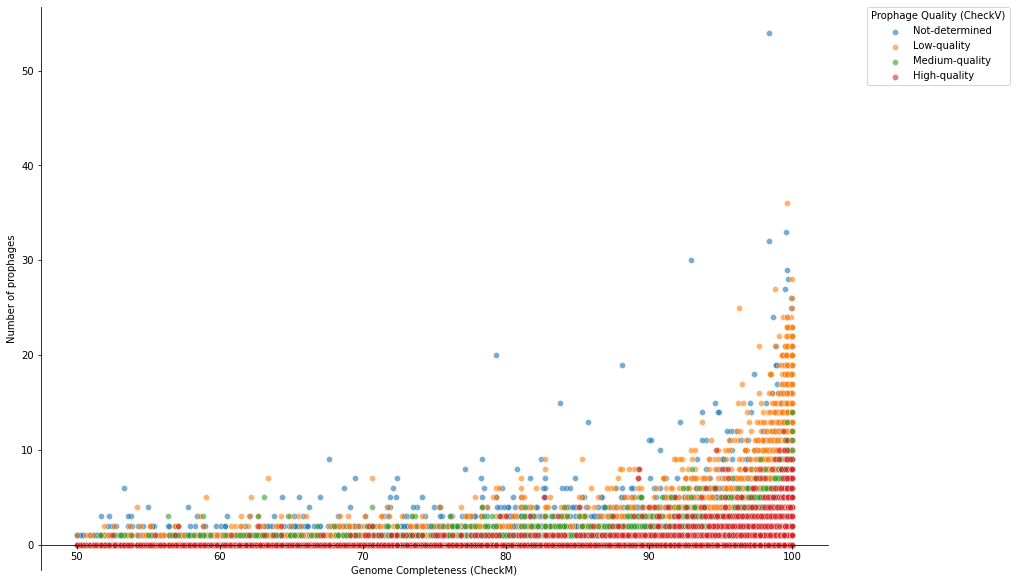

In [20]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    sns.scatterplot(x='checkm_completeness', y=c, data=checkmv, marker='o', ax=ax, label=c, alpha=0.6)

#sns.lineplot(x='checkm_round', y='Kept', data=checkmv, color='k', ax=ax, label='All predictions', alpha=0.6)

ax.set_ylabel('Number of prophages')
ax.set_xlabel('Genome Completeness (CheckM)')
ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(title="Prophage Quality (CheckV)", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig('images/checkm_checkv.png')
fig.savefig('images/checkm_checkv.svg')


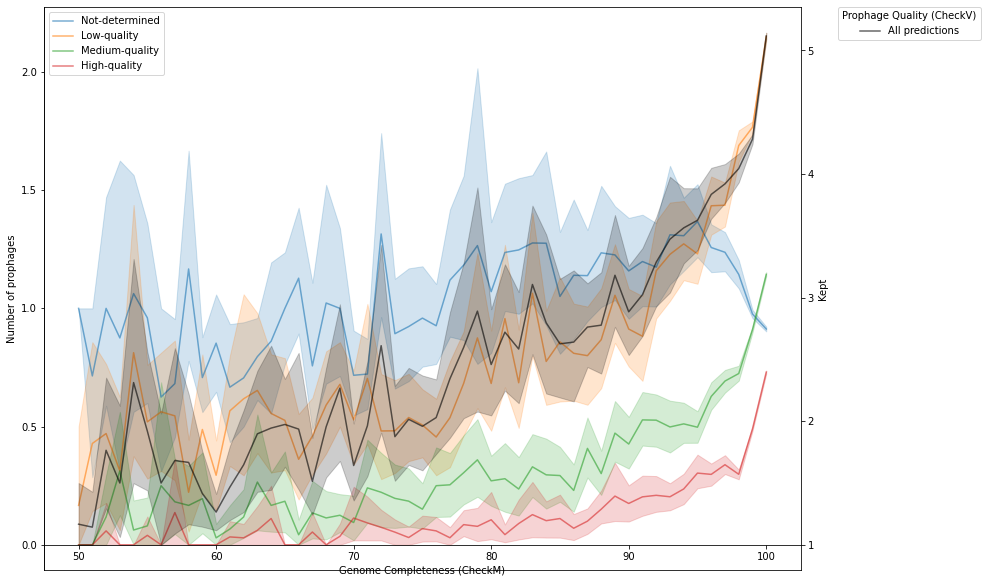

In [21]:
fig, ax = plt.subplots(1,1, figsize=(11.7,8.27))
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    sns.lineplot(x='checkm_round', y=c, data=checkmv, ax=ax, label=c, alpha=0.6)

ax2 = ax.twinx()
sns.lineplot(x='checkm_round', y='Kept', data=checkmv, color='k', ax=ax2, label='All predictions', alpha=0.6)

ax.set_ylabel('Number of prophages')
ax.set_xlabel('Genome Completeness (CheckM)')
ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


plt.tight_layout()
l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
l.set_title("Prophage Quality (CheckV)")

# Taxonomy

Extract the taxonomy from the GTDB table

In [22]:
tc = ['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']
gc = ['accession', 'gtdb_genome_representative', 'gtdb_representative', 'gtdb_taxonomy', 'gtdb_type_designation', 'gtdb_type_designation_sources', 'gtdb_type_species_of_genus']
gtdbex = pd.concat([gtdb[acccol], gtdb[tc], gtdb[gc]], axis=1)
gtdbex

,assembly_accession,domain,phylum,class,order,family,genus,species,accession,gtdb_genome_representative,gtdb_representative,gtdb_taxonomy,gtdb_type_designation,gtdb_type_designation_sources,gtdb_type_species_of_genus
0,GCA_000006155.2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A anthracis,GB_GCA_000006155.2,RS_GCF_000534935.2,f,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...,not type material,NaN,f
1,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,GB_GCA_000007385.1,RS_GCF_004136375.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
2,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,GB_GCA_000008605.1,RS_GCF_000410535.2,f,d__Bacteria;p__Spirochaetota;c__Spirochaetia;o...,not type material,NaN,f
3,GCA_000010565.1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,GB_GCA_000010565.1,GB_GCA_000010565.1,t,d__Bacteria;p__Firmicutes_B;c__Desulfotomaculi...,type strain of species,LPSN; DSMZ; StrainInfo,t
4,GCA_000013845.2,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens,GB_GCA_000013845.2,RS_GCF_000013285.1,f,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__C...,not type material,NaN,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191522,GCA_902166935.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166935.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
191523,GCA_902166945.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella pneumoniae,RS_GCF_902166945.1,RS_GCF_000742135.1,f,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,not type material,NaN,f
191524,GCA_902167295.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A,RS_GCF_902167295.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,NaN,f
191525,GCA_902167305.1,Bacteria,Bacteroidota,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophaga,Chitinophaga pinensis_A,RS_GCF_902167305.1,RS_GCF_902167325.1,f,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,not type material,NaN,f


### Do we need to combine to different levels

We can combined e.g. from Bacteria to Order. But do we need to?

In [23]:
toorder = len(pd.unique(gtdbex.apply(lambda x: '_'.join(x[1:5].values.tolist()), axis=1)))
uniqueorder = len(pd.unique(gtdbex['order']))
print(f"Unique orders: {uniqueorder} Unique to order: {toorder}")

Unique orders: 930 Unique to order: 930


[According to Donovan, they should be unique](https://forum.gtdb.ecogenomic.org/t/uniqueness-of-names-across-the-taxonomy/137) so we don't need to merge the columns! 

## Merge the data frames

Merge the GTDB taxonomy with the prophage counts into a single df

In [24]:
cvtax = pd.merge(gtdbex[['assembly_accession', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']], checkvcounts, on='assembly_accession', how='inner')
cvtax = pd.merge(cvtax, phagesdf[['assembly_accession', 'No phage genes', 'Kept']], on='assembly_accession', how='inner')
cvtax

,assembly_accession,domain,phylum,class,order,family,genus,species,Not-determined,Low-quality,Medium-quality,High-quality,Complete,No phage genes,Kept
0,GCA_000007385.1,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xanthomonas,Xanthomonas oryzae,2.0,1.0,1.0,0.0,0.0,12.0,4.0
1,GCA_000008605.1,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema,Treponema pallidum,0.0,1.0,0.0,0.0,0.0,2.0,1.0
2,GCA_000010565.1,Bacteria,Firmicutes_B,Desulfotomaculia,Desulfotomaculales,Pelotomaculaceae,Pelotomaculum,Pelotomaculum thermopropionicum,1.0,0.0,0.0,1.0,0.0,9.0,2.0
3,GCA_000013845.2,Bacteria,Firmicutes_A,Clostridia,Clostridiales,Clostridiaceae,Clostridium_P,Clostridium_P perfringens,1.0,0.0,1.0,0.0,0.0,4.0,2.0
4,GCA_000014305.1,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus suis,3.0,1.0,0.0,0.0,0.0,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113141,GCA_902158655.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,0.0,1.0,1.0,2.0,0.0,6.0,4.0
113142,GCA_902158685.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,0.0,0.0,1.0,1.0,0.0,4.0,2.0
113143,GCA_902158695.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,1.0,0.0,1.0,3.0,0.0,4.0,5.0
113144,GCA_902158715.1,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Klebsiella_A,Klebsiella_A grimontii,0.0,1.0,0.0,0.0,0.0,10.0,1.0


In [25]:
tdf = pd.DataFrame(cvtax.groupby('genus')['Kept'].agg(sum)).reset_index()
tdf

,genus,Kept
0,0-14-3-00-41-53,5.0
1,01-FULL-43-11b,1.0
2,01-FULL-45-10b,3.0
3,01-FULL-48-32b,1.0
4,02-FULL-45-11b,1.0
...,...,...
4233,Zoogloea,3.0
4234,Zooshikella,16.0
4235,Zunongwangia,21.0
4236,Zymobacter,4.0


In [26]:
tdf[tdf['genus'] == 'Bacteroides']

,genus,Kept
617,Bacteroides,2927.0


In [27]:
for c in ['Not-determined', 'Low-quality', 'Medium-quality', 'High-quality']:
    print(cvtax[c].mean())

0.9524243013451646
1.97900058331713
1.033867746097962
0.6275785268591024


### Make a plot

This makes a plot of the data, and sets the labels to be readable.

In [28]:
phsum = cvtax.groupby('phylum').agg('sum').reset_index()
phsum.sort_values(ascending=False, by='Kept')

,phylum,Not-determined,Low-quality,Medium-quality,High-quality,Complete,No phage genes,Kept
72,Proteobacteria,54638.0,151637.0,72169.0,45173.0,2713.0,400331.0,337491.0
41,Firmicutes,20987.0,41184.0,33521.0,21347.0,754.0,159862.0,118819.0
5,Actinobacteriota,16664.0,16205.0,4254.0,1979.0,135.0,149673.0,41806.0
42,Firmicutes_A,6054.0,7876.0,4354.0,1674.0,149.0,26410.0,20296.0
10,Bacteroidota,4154.0,3272.0,1168.0,377.0,3.0,23431.0,9339.0
...,...,...,...,...,...,...,...,...
79,Sumerlaeota,0.0,1.0,0.0,0.0,0.0,5.0,1.0
50,GCA-001730085,1.0,0.0,0.0,0.0,0.0,3.0,1.0
2,ARS69,1.0,0.0,0.0,0.0,0.0,7.0,1.0
92,Wallbacteria,1.0,0.0,0.0,0.0,0.0,3.0,1.0


### Distribution of prophages in different phyla


In [29]:
phsum[phsum['Kept'] < 5].sort_values(ascending=False, by='Kept').shape

(34, 8)

In [30]:
phsum.sort_values(ascending=False, by='Kept').head(25)

,phylum,Not-determined,Low-quality,Medium-quality,High-quality,Complete,No phage genes,Kept
72,Proteobacteria,54638.0,151637.0,72169.0,45173.0,2713.0,400331.0,337491.0
41,Firmicutes,20987.0,41184.0,33521.0,21347.0,754.0,159862.0,118819.0
5,Actinobacteriota,16664.0,16205.0,4254.0,1979.0,135.0,149673.0,41806.0
42,Firmicutes_A,6054.0,7876.0,4354.0,1674.0,149.0,26410.0,20296.0
10,Bacteroidota,4154.0,3272.0,1168.0,377.0,3.0,23431.0,9339.0
18,Campylobacterota,951.0,1063.0,529.0,157.0,6.0,5663.0,2724.0
23,Cyanobacteria,960.0,395.0,55.0,6.0,1.0,11681.0,1562.0
78,Spirochaetota,243.0,730.0,149.0,11.0,0.0,2468.0,1219.0
28,Desulfobacterota,322.0,218.0,120.0,46.0,0.0,2099.0,726.0
62,Myxococcota,315.0,162.0,38.0,17.0,0.0,6642.0,638.0


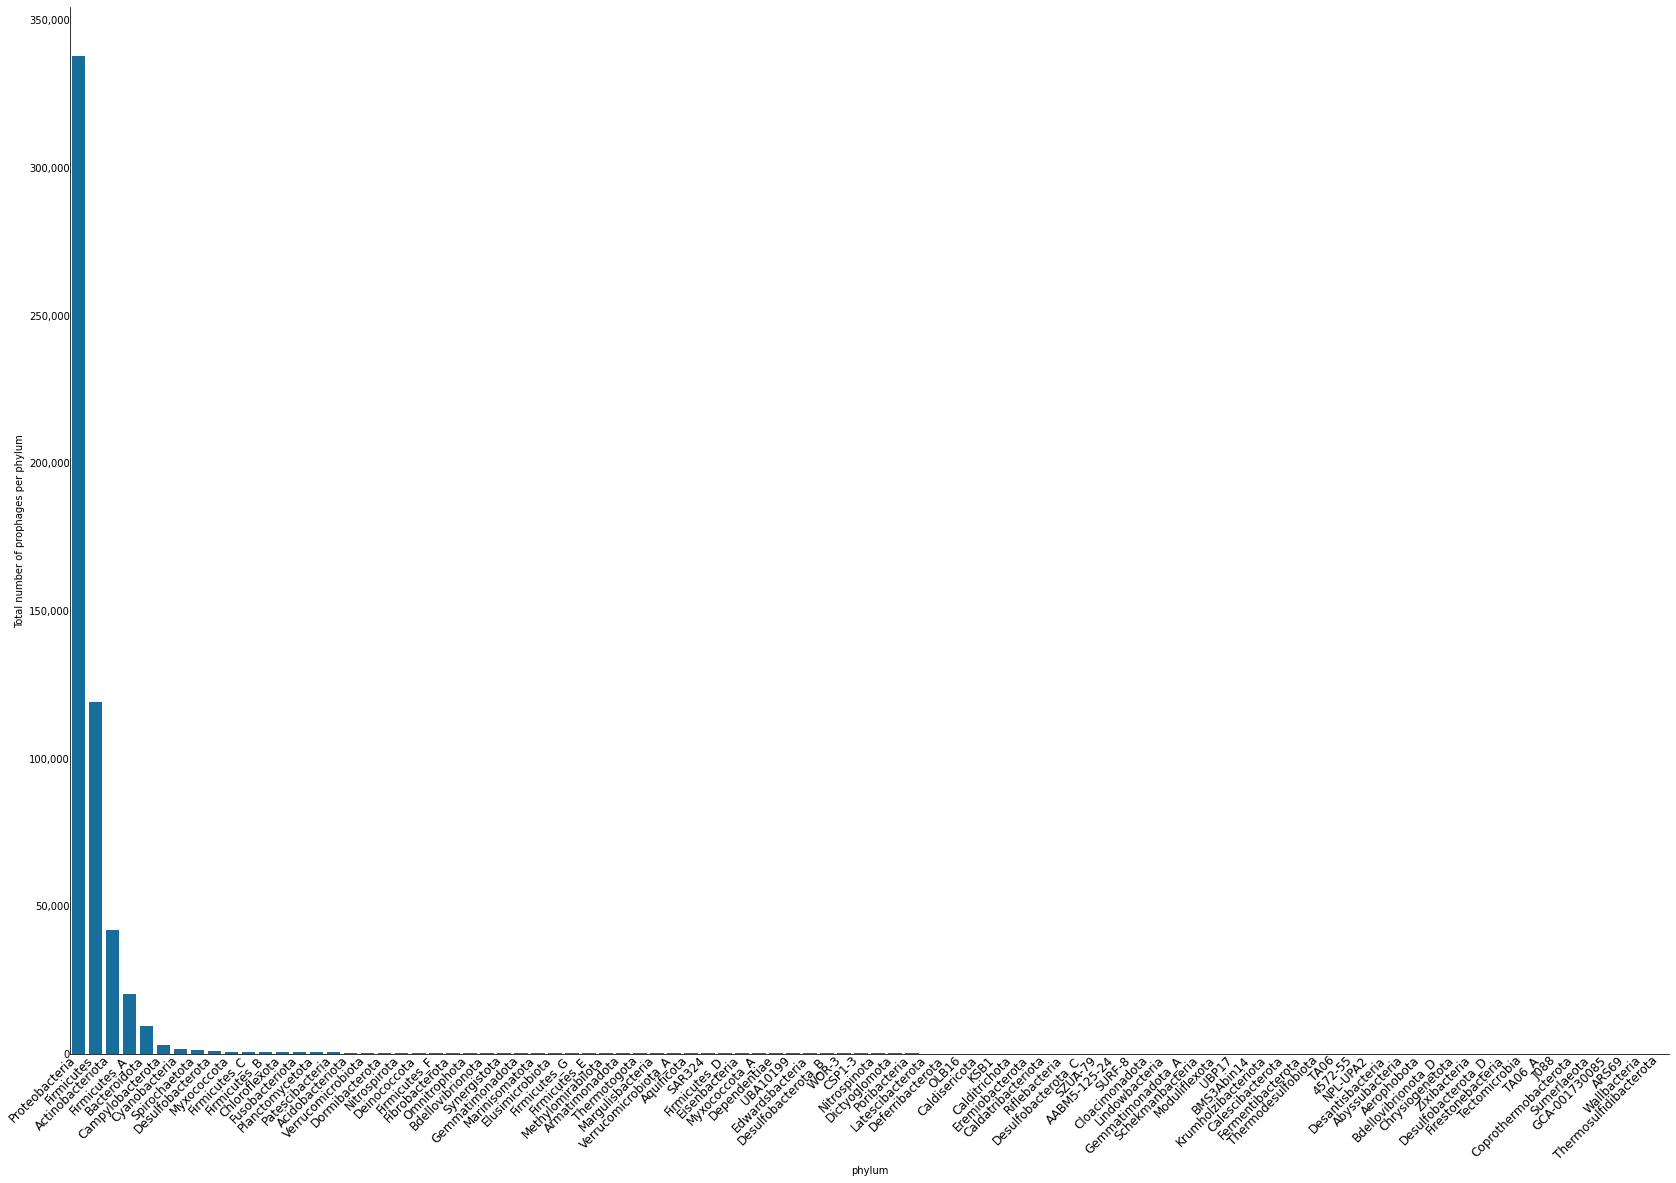

In [38]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='Kept', data=phsum.sort_values(ascending=False, by='Kept'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=12)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla")

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phylaTotal.png')
fig.savefig('images/phylaTotal.svg')

C:\Users\edwa0468\AppData\Local\Temp/ipykernel_21616/4144622031.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=48)


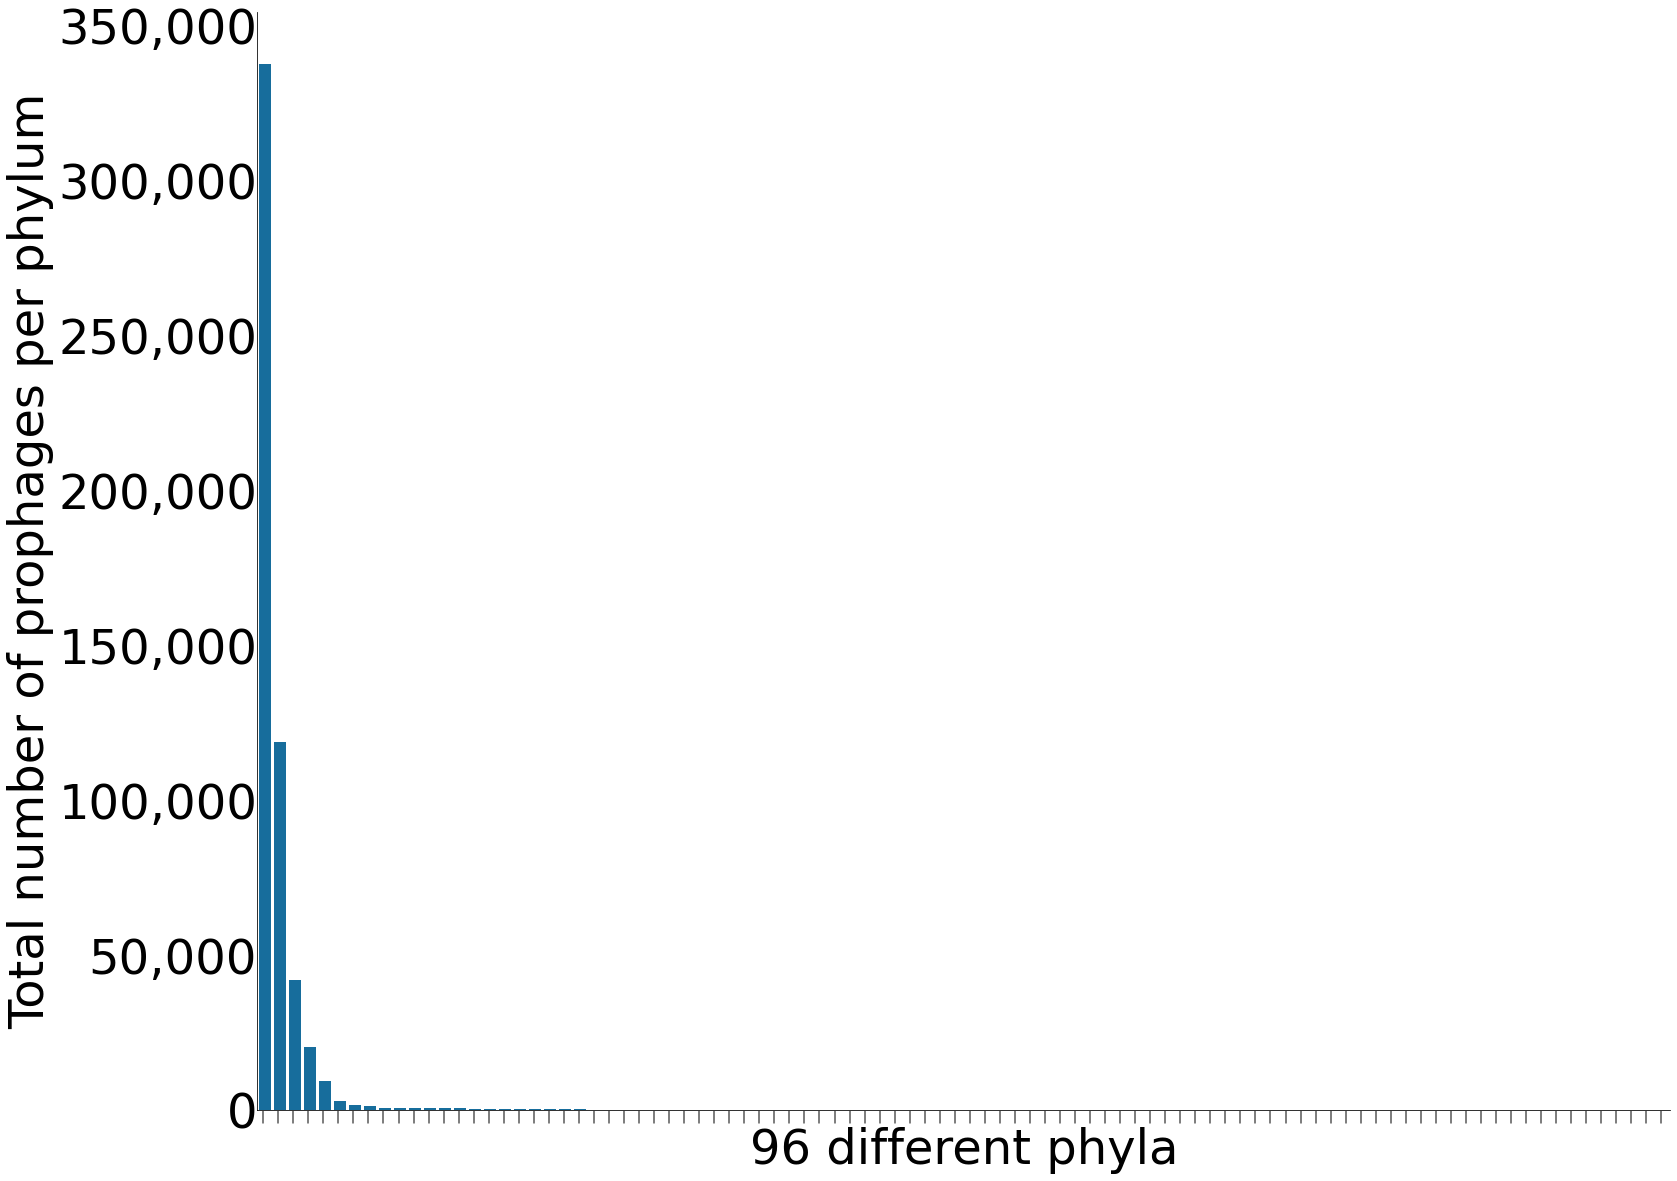

In [66]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='Kept', data=phsum.sort_values(ascending=False, by='Kept'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
#ticks_loc = ax.get_xticklabels()
ticks_loc = ['|' for x in ax.get_xticklabels()]
l = ax.set_xticklabels(ticks_loc, horizontalalignment='right', fontsize=12)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=48)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla")

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

"""
ax.grid(False)
ax.xaxis.grid(True, which="major")
"""


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum', fontsize=48)
ax.set_xlabel('96 different phyla', fontsize=48)
plt.tight_layout()
#fig.savefig('images/phylaTotalNoLabelsLargeFont.png')
fig.savefig('images/phylaTotalNoLabelsLargeFont.svg')

In [72]:
phsum.sort_values(ascending=False, by='Kept')[0:10]

,phylum,Not-determined,Low-quality,Medium-quality,High-quality,Complete,No phage genes,Kept,npgp
72,Proteobacteria,54638.0,151637.0,72169.0,45173.0,2713.0,400331.0,337491.0,0.542585
41,Firmicutes,20987.0,41184.0,33521.0,21347.0,754.0,159862.0,118819.0,0.573638
5,Actinobacteriota,16664.0,16205.0,4254.0,1979.0,135.0,149673.0,41806.0,0.781668
42,Firmicutes_A,6054.0,7876.0,4354.0,1674.0,149.0,26410.0,20296.0,0.565452
10,Bacteroidota,4154.0,3272.0,1168.0,377.0,3.0,23431.0,9339.0,0.715014
18,Campylobacterota,951.0,1063.0,529.0,157.0,6.0,5663.0,2724.0,0.675212
23,Cyanobacteria,960.0,395.0,55.0,6.0,1.0,11681.0,1562.0,0.882051
78,Spirochaetota,243.0,730.0,149.0,11.0,0.0,2468.0,1219.0,0.669379
28,Desulfobacterota,322.0,218.0,120.0,46.0,0.0,2099.0,726.0,0.743009
62,Myxococcota,315.0,162.0,38.0,17.0,0.0,6642.0,638.0,0.912363


C:\Users\edwa0468\AppData\Local\Temp/ipykernel_21616/3646101586.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


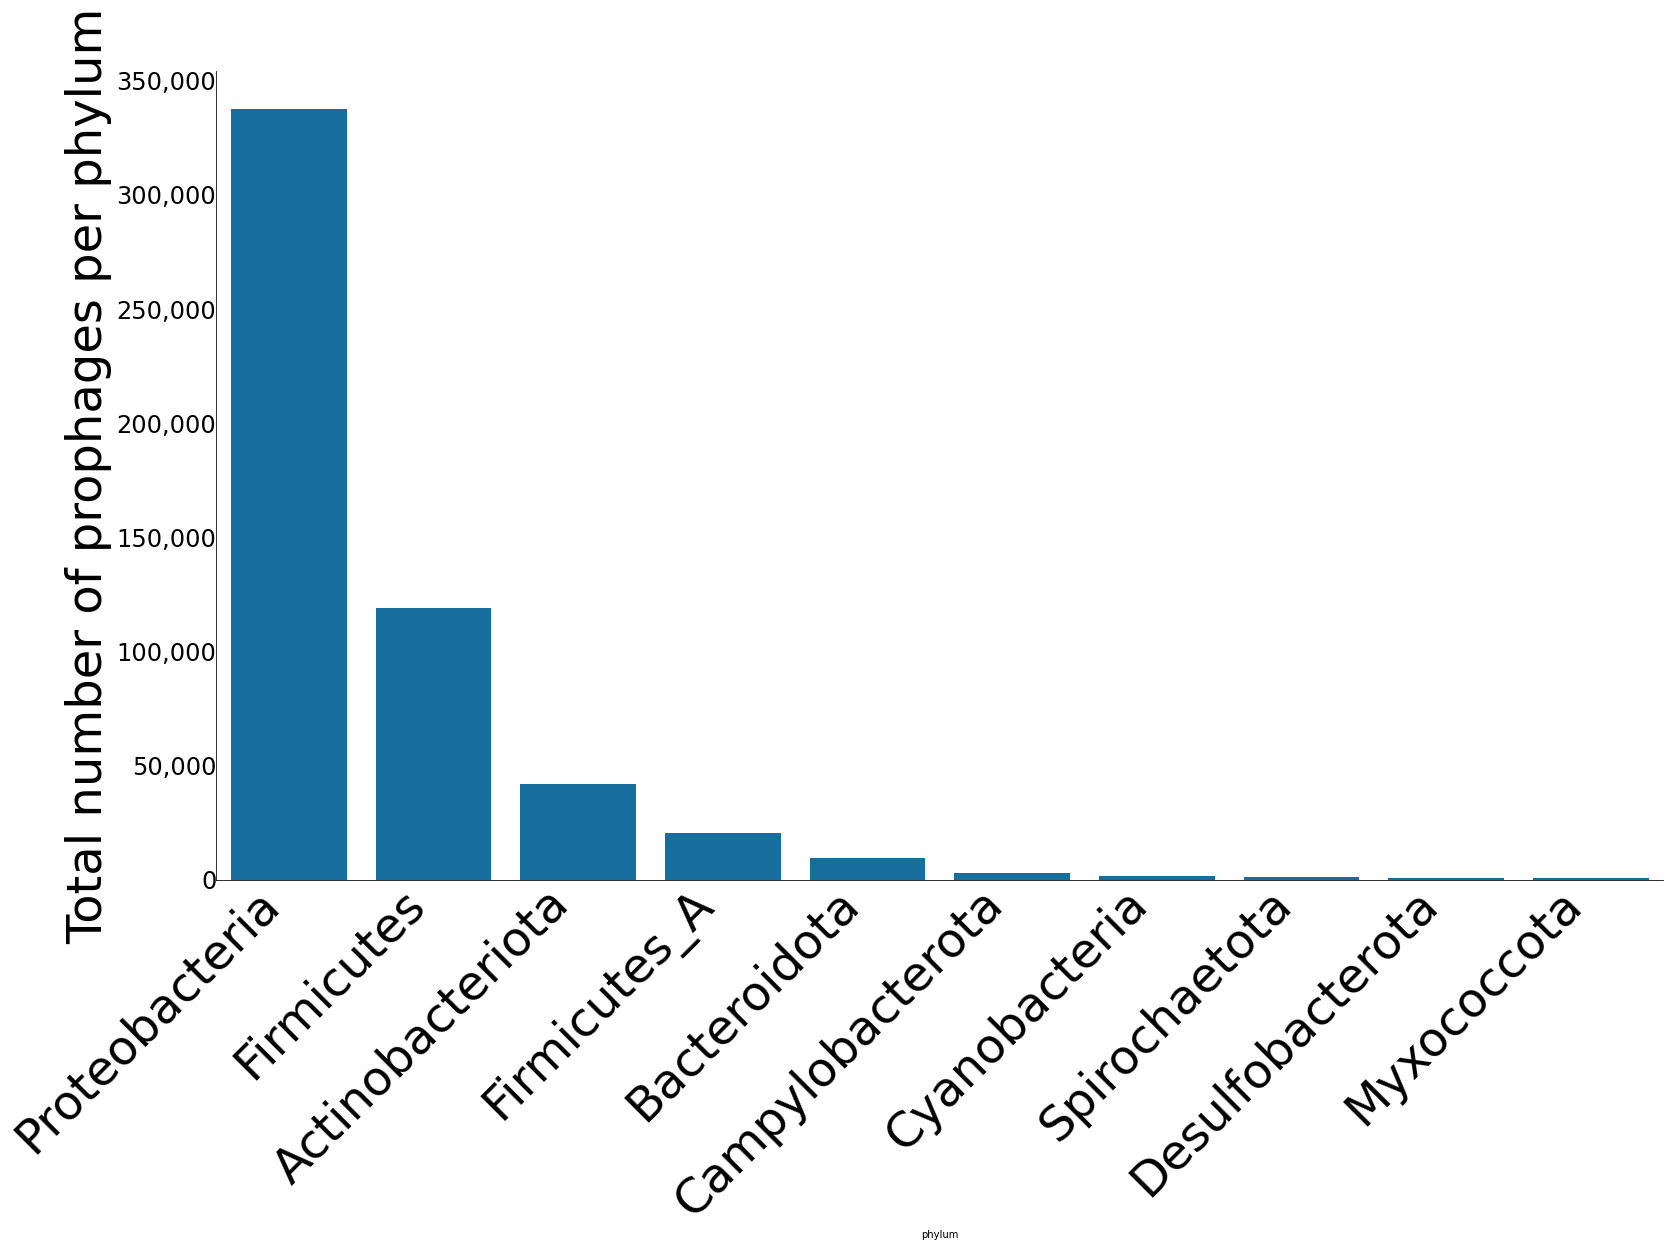

In [73]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='Kept', data=phsum.sort_values(ascending=False, by='Kept')[0:10], ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=48)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla (phyla with >500 prophages)", fontsize=24)

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum', fontsize=48)
#ax.set_xlabel('Phyla', fontsize=48)
plt.tight_layout()
#fig.savefig('images/phylaTotal_top10LargeFont.png')
fig.savefig('images/phylaTotal_top10LargeFont.svg')

C:\Users\edwa0468\AppData\Local\Temp/ipykernel_21616/2368457327.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


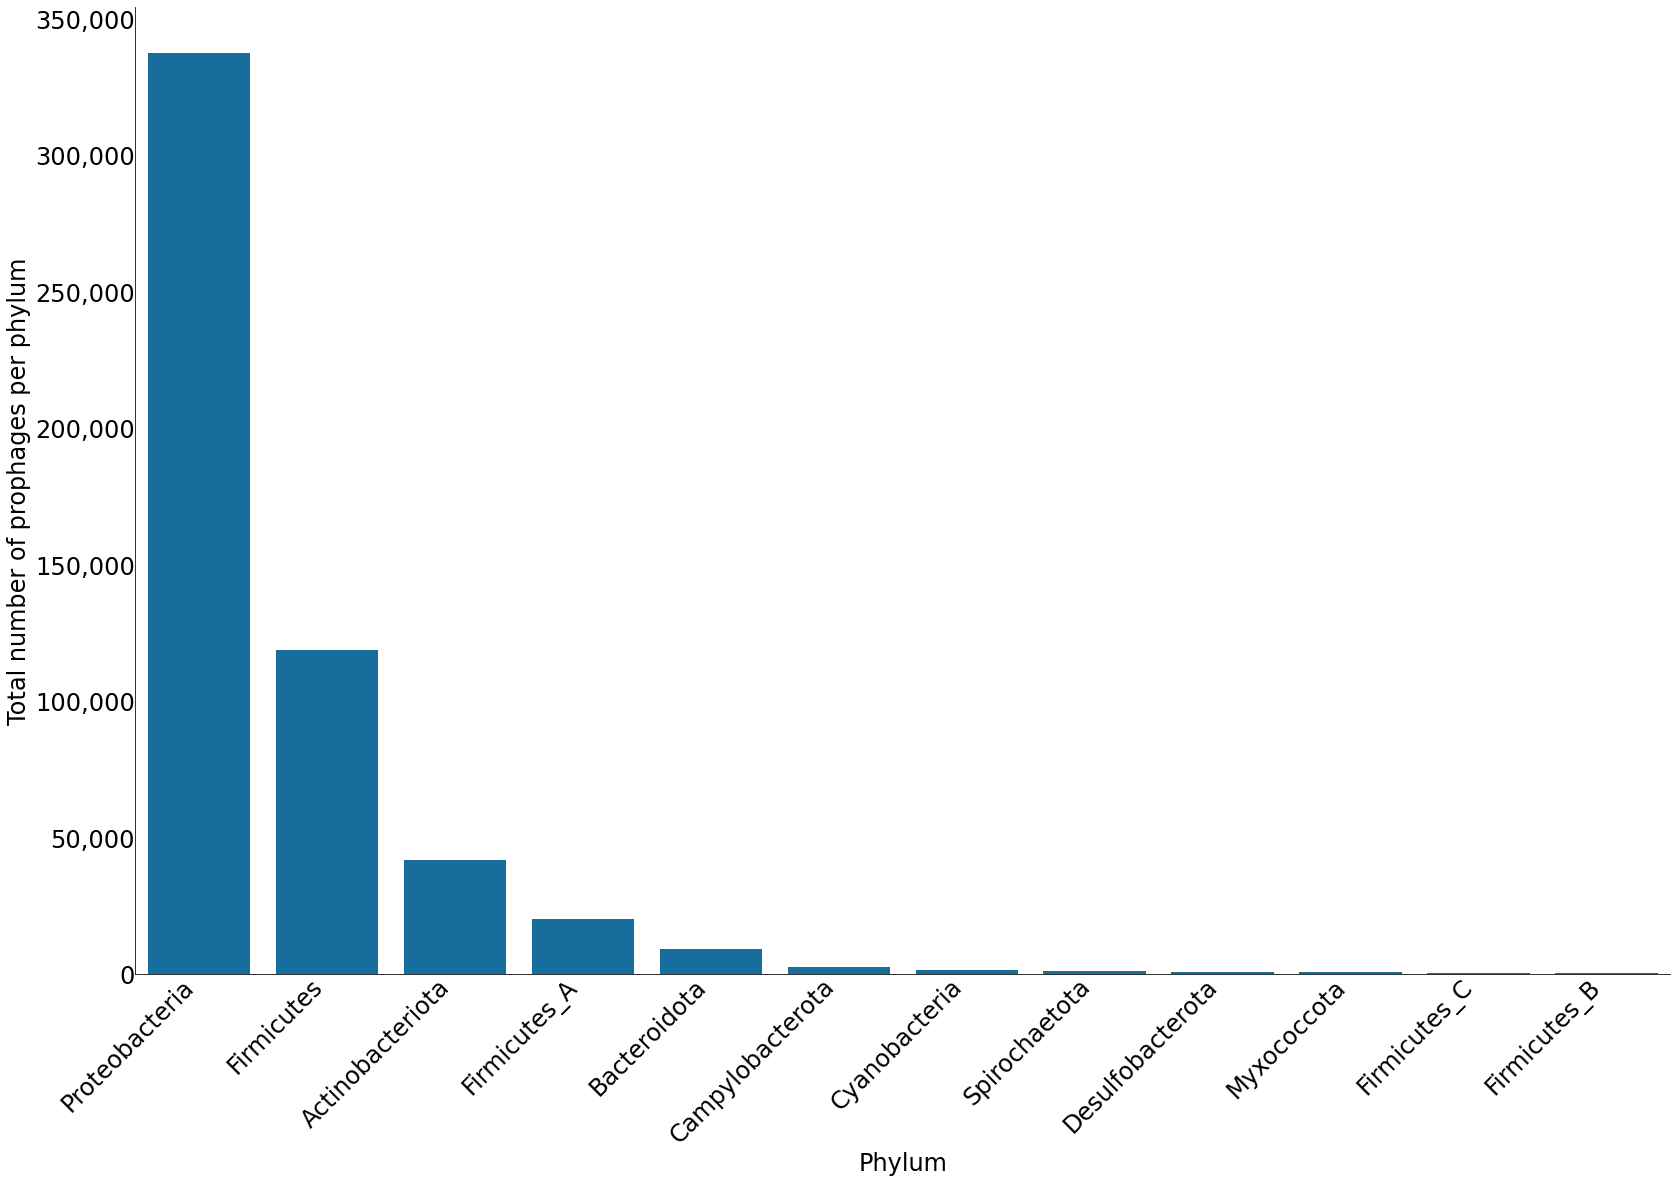

In [32]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='Kept', data=phsum[phsum['Kept']>450].sort_values(ascending=False, by='Kept'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=24)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla (phyla with >500 prophages)", fontsize=24)

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Total number of prophages per phylum', fontsize=24)
ax.set_xlabel('Phylum', fontsize=24)
plt.tight_layout()
fig.savefig('images/phylaTotal_top500.png')
fig.savefig('images/phylaTotal_top500.svg')

In [33]:
tx = "**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from"
for idx, row in cvtax.groupby('phylum').sum().sort_values(by='Kept', ascending=False).head(5).iterrows():
    tx += f" {idx} ({int(row['Kept']):,} phages),"
printmd(tx)


<span style='color:black'>**Fig. S\*\* Phages predicted per bacterial phyla.** Most of the predictions are from Proteobacteria (337,491 phages), Firmicutes (118,819 phages), Actinobacteriota (41,806 phages), Firmicutes_A (20,296 phages), Bacteroidota (9,339 phages),</span>

## What about the kept/No phage genes?

The "No phage genes" column represents those cases where we are unable to find a homolog in the databases. Do we see more of those in the unkown genomes than the known genomes?

In [34]:
phsum['npgp'] = phsum['No phage genes']/(phsum['No phage genes'] + phsum['Kept'])
phsum

,phylum,Not-determined,Low-quality,Medium-quality,High-quality,Complete,No phage genes,Kept,npgp
0,4572-55,2.0,0.0,0.0,0.0,0.0,13.0,2.0,0.866667
1,AABM5-125-24,2.0,1.0,0.0,0.0,0.0,25.0,4.0,0.862069
2,ARS69,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.875000
3,Abyssubacteria,2.0,0.0,0.0,0.0,0.0,4.0,2.0,0.666667
4,Acidobacteriota,177.0,55.0,11.0,3.0,0.0,5129.0,311.0,0.942831
...,...,...,...,...,...,...,...,...,...
89,Verrucomicrobiota,144.0,60.0,33.0,16.0,3.0,3821.0,277.0,0.932406
90,Verrucomicrobiota_A,16.0,5.0,0.0,1.0,0.0,110.0,26.0,0.808824
91,WOR-3,8.0,3.0,0.0,0.0,0.0,36.0,11.0,0.765957
92,Wallbacteria,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.750000


C:\Users\edwa0468\AppData\Local\Temp/ipykernel_21616/1946221140.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


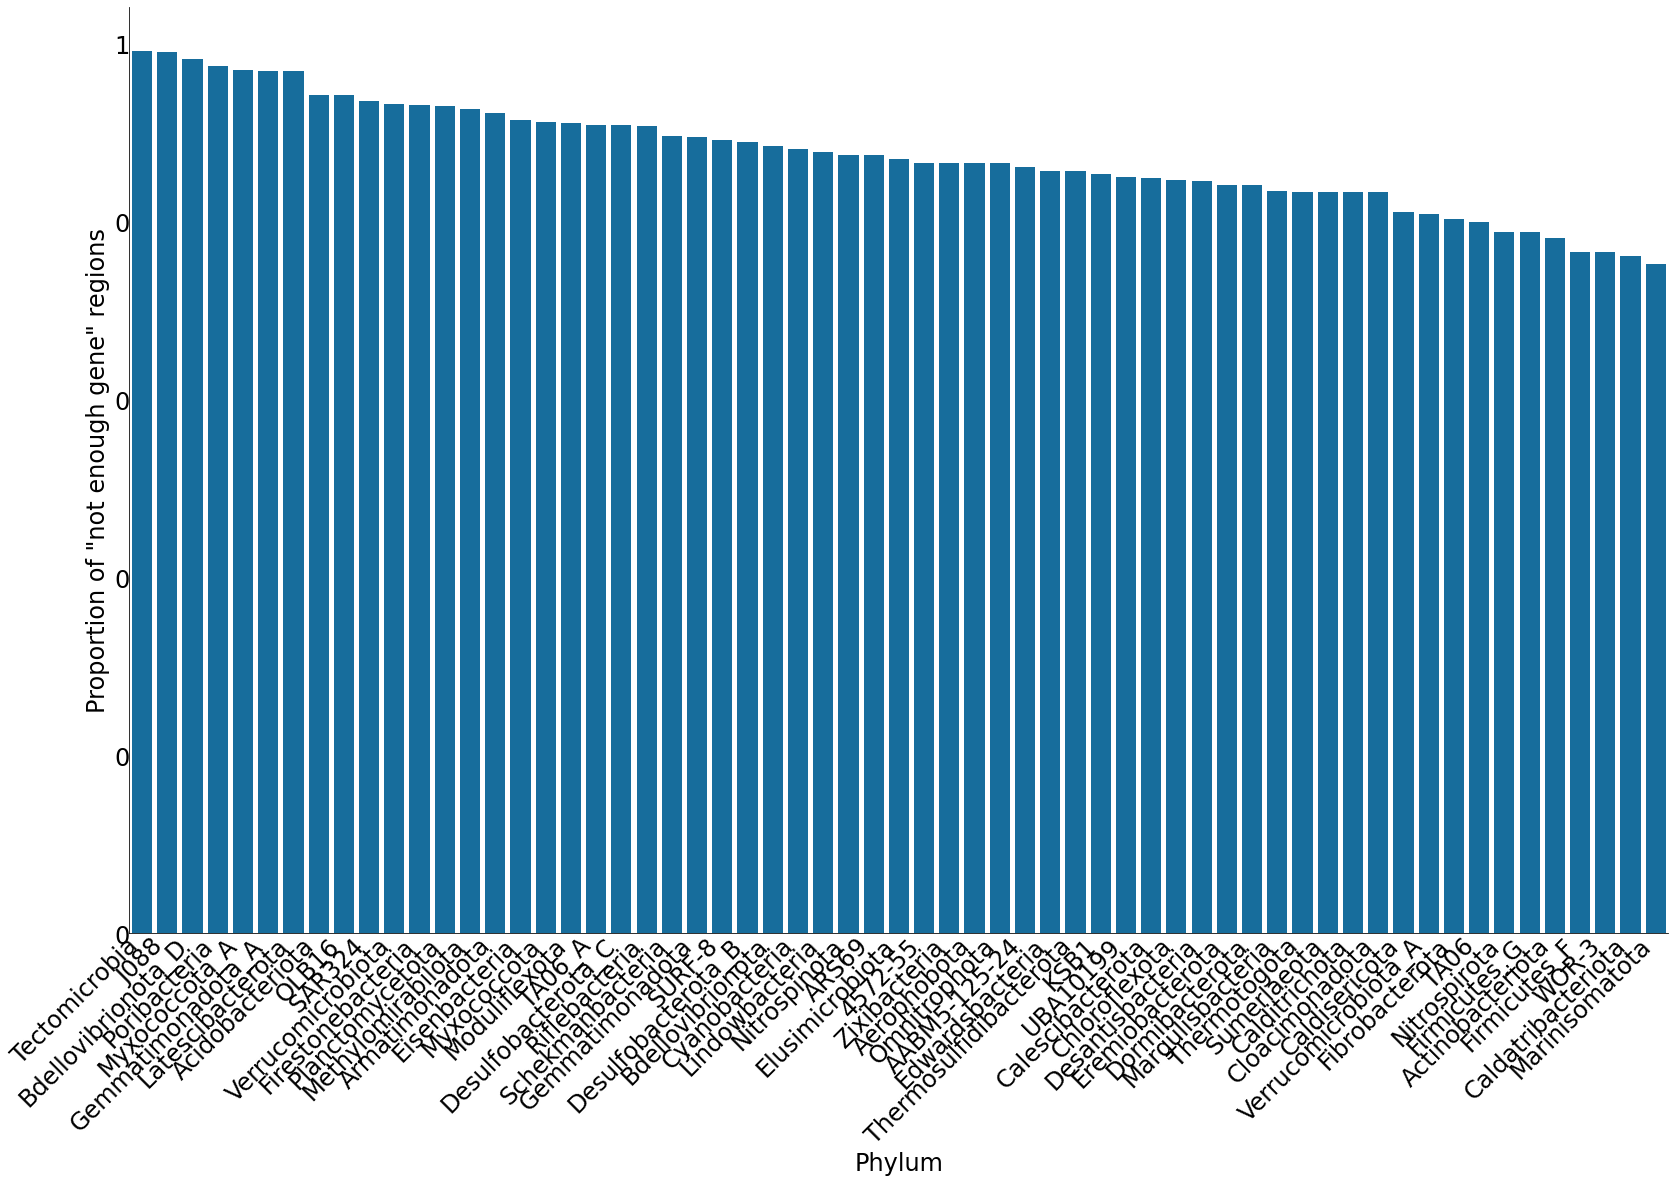

In [39]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='npgp', data=phsum[phsum['npgp']>0.75].sort_values(ascending=False, by='npgp'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=24)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla (phyla with >500 prophages)", fontsize=24)

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Proportion of "not enough gene" regions', fontsize=24)
ax.set_xlabel('Phylum', fontsize=24)
plt.tight_layout()
#fig.savefig('images/negp_0.5.png')
#fig.savefig('images/negp_0.5.svg')

C:\Users\edwa0468\AppData\Local\Temp/ipykernel_21616/1946221140.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)


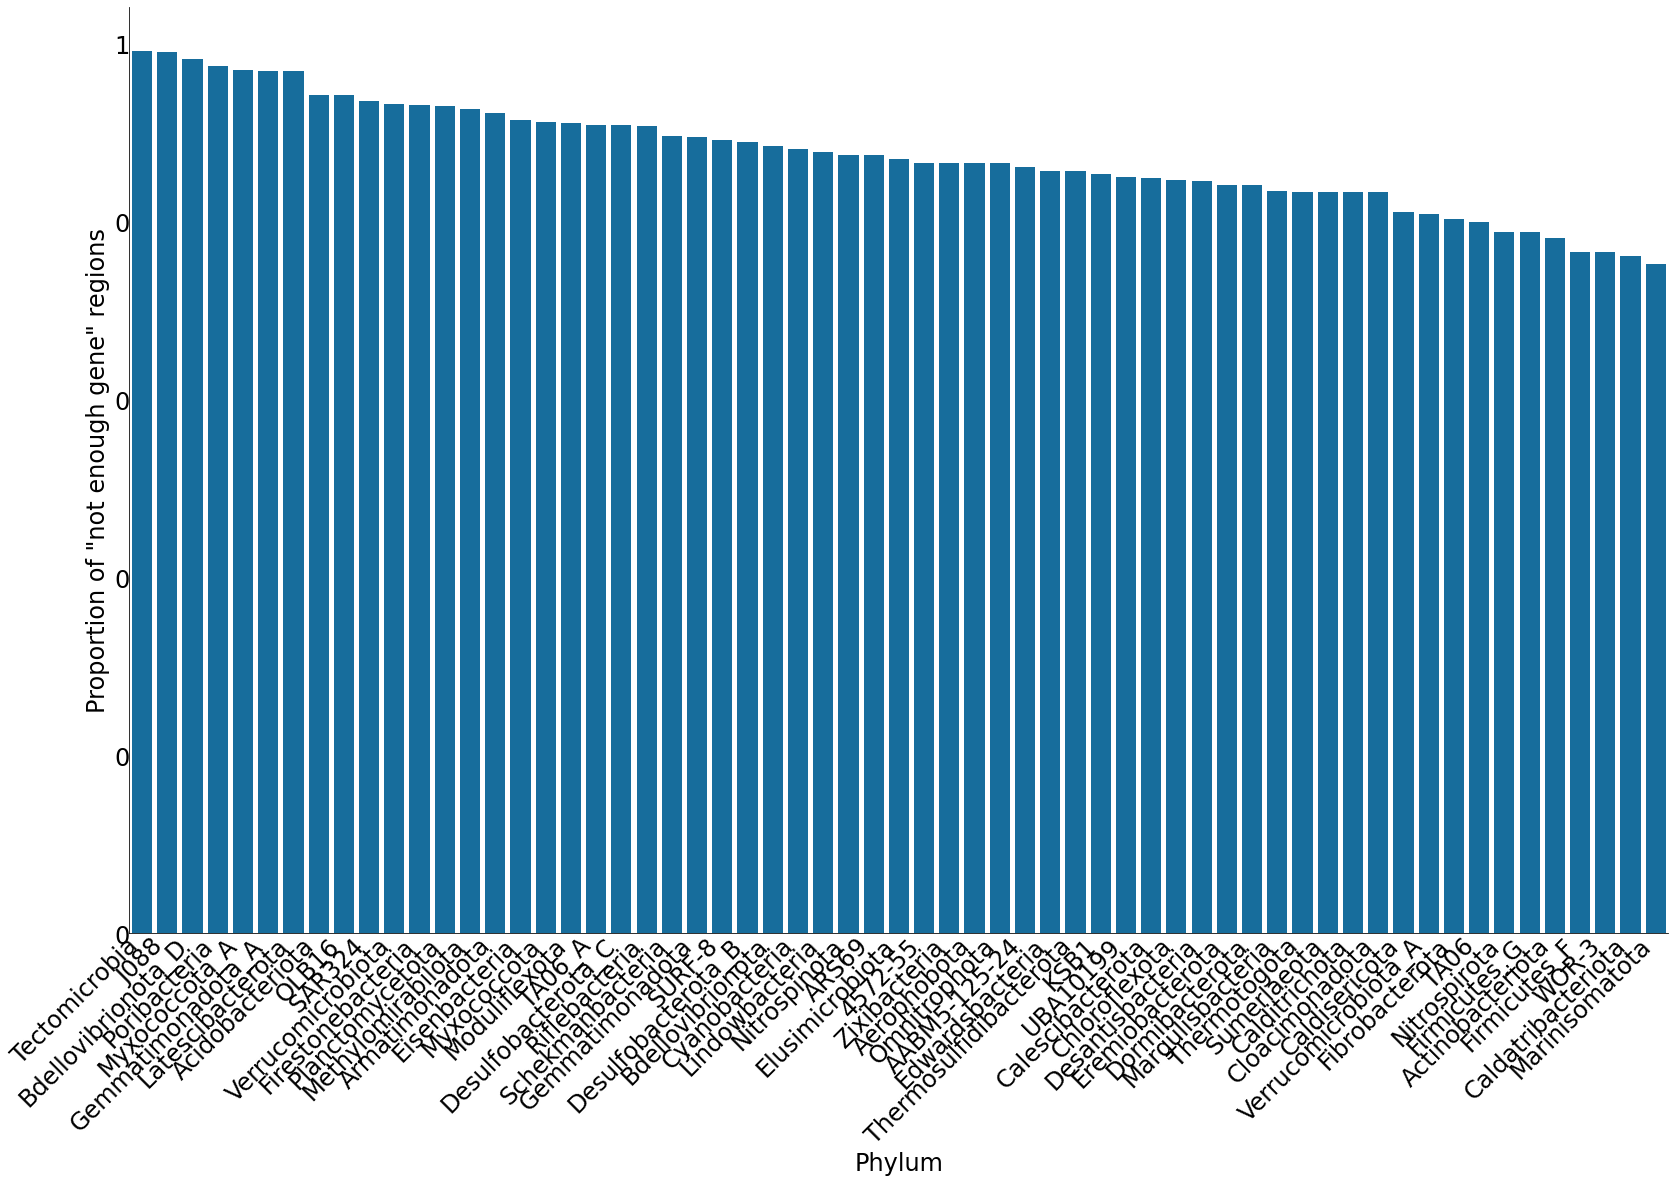

In [40]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x='phylum', y='npgp', data=phsum[phsum['npgp']>0.75].sort_values(ascending=False, by='npgp'), ax=ax, label=c, color=sns.color_palette("colorblind")[0])

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
l = ax.set_xticklabels(ticks_loc, rotation=45, horizontalalignment='right', fontsize=24)

ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x), ',')))
                                   
#ax.set_title(f"Total number of prophages per phyla (phyla with >500 prophages)", fontsize=24)

# add a slight offset for every other tick label

"""
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))
"""

ax.grid(False)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Proportion of "not enough gene" regions', fontsize=24)
ax.set_xlabel('Phylum', fontsize=24)
plt.tight_layout()
#fig.savefig('images/negp_0.5.png')
#fig.savefig('images/negp_0.5.svg')

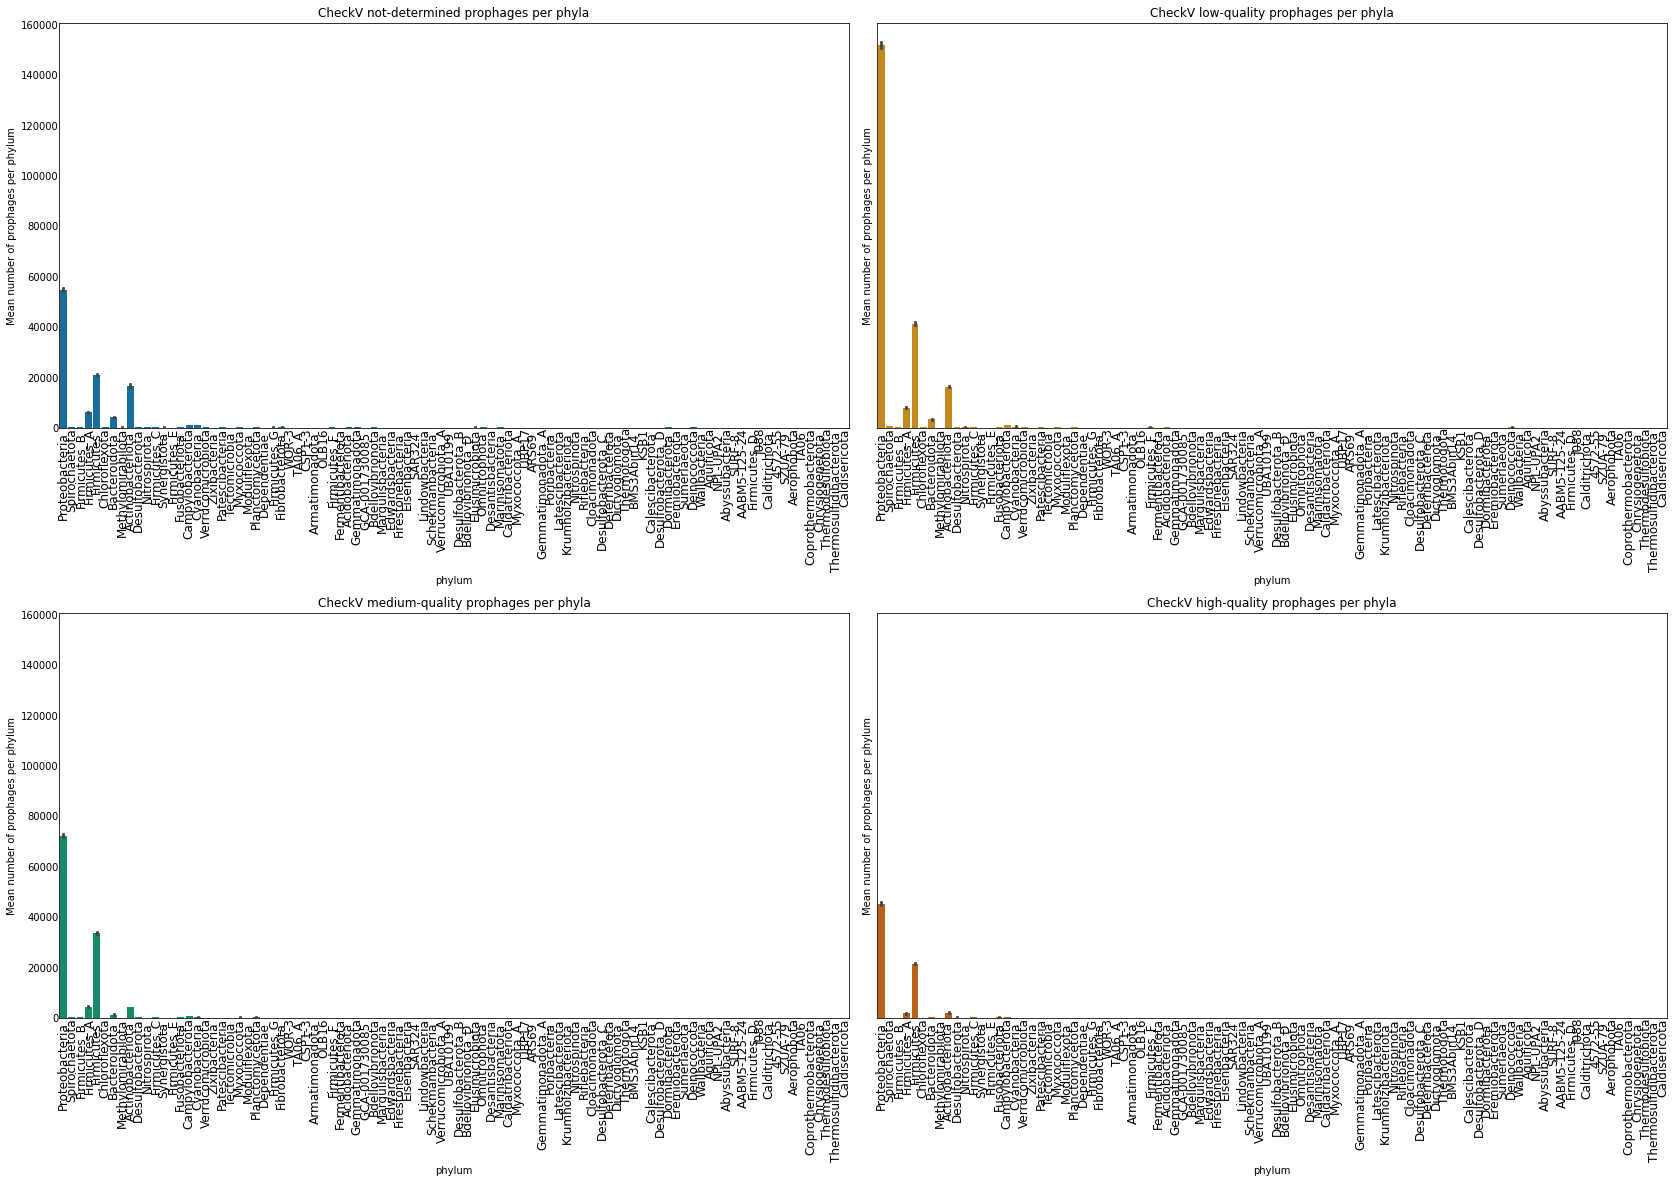

In [41]:
fig, axes = plt.subplots(2,2, figsize=(23.4,16.54), sharey=True)

col =  [['Not-determined', 'Low-quality'], ['Medium-quality', 'High-quality']]

for i in 0, 1:
    for j in 0, 1:
        c = col[i][j]
        ax = axes[i][j]
        sns.barplot(x='phylum', y=c, data=cvtax, ax=ax, label=c, color=sns.color_palette("colorblind")[(2*i) + j], estimator=sum)

        # get the tick labels and change some parameters about them.
        ticks_loc = ax.get_xticklabels()
        l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
        # use this to hide every other tick
        # [x.set_visible(False) for x in l[::2]]

        ax.set_title(f"CheckV {c.lower()} prophages per phyla")
        # add a slight offset for every other tick label
        for alab in l[::2]:
            x, y = alab.get_position()
            alab.set_position((x, y-0.01))

        # turn off the ticks themselves
        ax.tick_params(length=0, pad=0)
        ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.png')
fig.savefig('images/phyla.svg')

# Compared to isolate phages

Please see the jupyter notebook `genbank_vs_prophage` for details on this.

The genbank data comes from [the Cook et al paper](https://www.biorxiv.org/content/10.1101/2021.05.01.442102v1) and especially their [supplemental material](https://www.biorxiv.org/content/10.1101/2021.05.01.442102v1.supplementary-material)

```
Cook R, Brown N, Redgwell T, Rihtman B, Barnes M, Stekel DJ, Clokie M, Hobman J, Jones M, Millard AD. 2021. INfrastructure for a PHAge REference Database: Identification of large-scale biases in the current collection of phage genomes. bioRxiv.
```

In [42]:
isolate_hosts = set()
with open('../data/Cook_unique_hosts.txt', 'r') as h:
    for l in h:
        if l.strip():
            isolate_hosts.add(l.strip())
isolate_phyla = {}
for h in isolate_hosts:
    phuq = pd.unique(gtdb[gtdb['genus'] == h]['phylum'])
    if len(phuq):
        for ph in phuq:
            isolate_phyla[ph] = isolate_phyla.get(ph, 0)+1
    else:
        isolate_phyla["unknown"] = isolate_phyla.get("unknown", 0)+1
isolate_phyla

{'Fusobacteriota': 1,
 'Proteobacteria': 92,
 'Actinobacteriota': 25,
 'Firmicutes': 28,
 'unknown': 49,
 'Cyanobacteria': 10,
 'Bacteroidota': 14,
 'Campylobacterota': 3,
 'Firmicutes_A': 7,
 'Bdellovibrionota': 1,
 'Verrucomicrobiota_A': 1,
 'Spirochaetota': 1,
 'Myxococcota': 1,
 'Thermotogota': 1,
 'Deinococcota': 2,
 'Aquificota': 1}

### Phyla for which we do not have isolated phages

In [43]:
for p in pd.unique(phsum[phsum['Kept']>0]['phylum'].sort_values()):
    if p not in isolate_phyla:
        print(p)


4572-55
AABM5-125-24
ARS69
Abyssubacteria
Acidobacteriota
Aerophobota
Armatimonadota
BMS3Abin14
Bdellovibrionota_D
CSP1-3
Caldatribacteriota
Caldisericota
Calditrichota
Calescibacterota
Chloroflexota
Chrysiogenetota
Cloacimonadota
Coprothermobacterota
Deferribacterota
Dependentiae
Desantisbacteria
Desulfobacterota
Desulfobacterota_B
Desulfobacterota_C
Desulfobacterota_D
Dictyoglomota
Dormibacterota
Edwardsbacteria
Eisenbacteria
Elusimicrobiota
Eremiobacterota
Fermentibacterota
Fibrobacterota
Firestonebacteria
Firmicutes_B
Firmicutes_C
Firmicutes_D
Firmicutes_E
Firmicutes_F
Firmicutes_G
GCA-001730085
Gemmatimonadota
Gemmatimonadota_A
J088
KSB1
Krumholzibacteriota
Latescibacterota
Lindowbacteria
Margulisbacteria
Marinisomatota
Methylomirabilota
Moduliflexota
Myxococcota_A
NPL-UPA2
Nitrospinota
Nitrospirota
OLB16
Omnitrophota
Patescibacteria
Planctomycetota
Poribacteria
Riflebacteria
SAR324
SURF-8
SZUA-79
Schekmanbacteria
Sumerlaeota
Synergistota
TA06
TA06_A
Tectomicrobia
Thermodesulfobio

In [44]:
for p in phsum[phsum['Kept']>0]:
    print(p)
    if p['phylum'] not in isolate_phyla:
        print(p)


phylum


TypeError: string indices must be integers

## What are some of the weird ones

In [ ]:
gtdb[gtdb['phylum'] == 'Firmicutes_C']

In [ ]:
gtdb


<div style="background-color:lightyellow">

    
<h1>Statistical Analyses</h1>
    

Some stats on the number of prophages per taxonomic classification
    </div>

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [ ]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

# Make sure the data is the same.

We are going to check the number of contigs, the number of basepairs

In [ ]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(cvtax['phylum'])):
    d = cvtax[cvtax['phylum'] == p]
    count = d.Kept.count()
    m = d.Kept.min()
    x = d.Kept.max()
    n = round(d.Kept.mean(), 2)
    e = round(d.Kept.median(), 2)
    s = round(d.Kept.std(), 2)
    if np.isnan(s):
        s = ""
    print("\t".join(map(str, [p, m, x, n, e, s])))

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [ ]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('phylum'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

### Repeat for order

Is there a significant difference in order

In [ ]:
samples = []
names = []
for nm, groupdf in cvtax.groupby('order'):
    names.append(nm)
    samples.append(groupdf['Kept'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

### Using statsmodels

Here we make a regression model on phylum.


In [ ]:
mod = ols('Kept ~ phylum', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

In [ ]:
mod = ols('Kept ~ order', data=cvtax).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {:,}) = {}, *p* = {}".format(
    int(aov_table.df['order']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['order'], 2),
    round(aov_table.get("PR(>F)")['order'], 4)
))

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [ ]:
rec = pairwise_tukeyhsd(cvtax['Kept'], cvtax['phylum'])
print(rec)

In [ ]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [ ]:
phyla = pd.unique(cvtax['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'], 
        ), 2)))

Make the effect size into a table so we can make a heat map of it!

In [ ]:
phyla = sorted(pd.unique(cvtax['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]



In [ ]:
cohendnz = cohend.loc[(cohend.sum(axis=1) != 0), (cohend.sum(axis=0) != 0)]
cohendnz

In [ ]:
cohenclean = cohendnz.fillna(0).replace(np.inf, 1).replace(-np.inf, -1)
cohenclean

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
# coolwarm is also a good color_palette
sns.heatmap(cohend,  cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)

lx = ax.xaxis.get_majorticklabels()
for alab in lx[1::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

ly = ax.yaxis.get_majorticklabels()
for alab in ly[1::2]:
    x, y = alab.get_position()
    alab.set_position((x+0.01, y))
    

plt.tight_layout()

In [ ]:
#fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))

# vlag is also a good color_palette
# coolwarm is also a good color_palette
# sns.heatmap(cohend,  cmap=sns.color_palette("vlag", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)
sns.set_theme(color_codes=True)
ax = sns.clustermap(
    cohenclean, 
    cmap=sns.color_palette("vlag", as_cmap=True),
    figsize=(23.4, 23.4),
)

"""
# get the tick labels and change some parameters about them.
xticks_loc = ax.get_xticklabels()
lx = ax.set_xticklabels(xticks_loc, fontsize=10)
# use this to hide every other tick
#[x.set_visible(False) for x in lx[::2]]

yticks_loc = ax.get_yticklabels()
ly = ax.set_yticklabels(yticks_loc, fontsize=10)
# use this to hide every other tick
#[y.set_visible(False) for y in ly[1::2]]


# add a slight offset for every other x tick label
for alab in lx[1::4]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# add a slight offset for every other y tick label
for alab in ly[2::4]:
    x, y = alab.get_position()
    alab.set_position((x-0.01, y))


"""

# plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=45)

lx = ax.ax_heatmap.xaxis.get_majorticklabels()
for alab in lx[1::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

ly = ax.ax_heatmap.yaxis.get_majorticklabels()
for alab in ly[1::2]:
    x, y = alab.get_position()
    alab.set_position((x+0.01, y))
    

plt.tight_layout()
plt.savefig('images/cohen_clustmap.png')
plt.savefig('images/cohen_clustmap.svg')

## Create a distance based on taxonomy

In [ ]:
gtdbex

In [ ]:
phyla = sorted(pd.unique(cvtax['phylum']))
phyladist = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    phyladist[p] = pd.to_numeric(phyladist[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(cvtax[cvtax['phylum'] == c]['Kept'], cvtax[cvtax['phylum'] == d]['Kept'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]

